Information Gain for each feature:

Gender: 0.0007
Age: 0.0013
BMI: 0.0003
Smoking: 0.0000
Exercise: 0.0054
Diabetes: 0.0001
Drinking_Habit: 0.0004
Hypertension: 0.0005


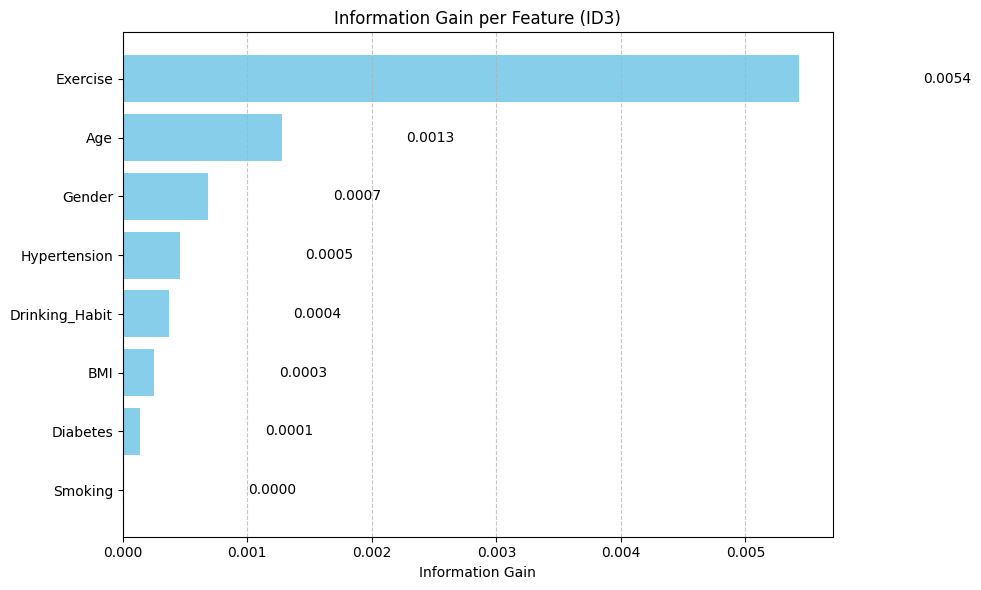

{'Exercise': {np.int64(0): {'Gender': {np.int64(0): {'BMI': {np.int64(0): np.int64(0),
                                                             np.int64(1): np.int64(0),
                                                             np.int64(2): np.int64(0)}},
                                       np.int64(1): {'Age': {np.int64(0): np.int64(0),
                                                             np.int64(1): np.int64(0),
                                                             np.int64(2): np.int64(0),
                                                             np.int64(3): np.int64(0),
                                                             np.int64(4): np.int64(0)}}}},
              np.int64(1): {'Age': {np.int64(0): {'Gender': {np.int64(0): np.int64(0),
                                                             np.int64(1): np.int64(0)}},
                                    np.int64(1): {'Gender': {np.int64(0): np.int64(0),
                                   

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from math import log2
import matplotlib.pyplot as plt
import networkx as nx

# Load and clean the dataset
df = pd.read_csv("sleep_health.csv")
df = df.dropna()

# Create the dataframe
df_2015 = pd.DataFrame({
    "Poor_Sleep": df["2015NRS"],
    "Gender": df["gender"],
    "Age": df["2015Age"],
    "BMI": df["2015BMI"],
    "Smoking": df["2015Smoking"],
    "Exercise": df["2015EX"],
    "Diabetes": df["2015Diabetes"],
    "Drinking_Habit": df["2015DrinkHabit"],
    "Hypertension" : df["2015Hypertension"]
})

# Bin Age and BMI
df_2015["Age"] = pd.cut(df_2015["Age"], bins=[39, 49, 59, 69, 74], labels=["40–49", "50–59", "60–69", "70–74"])
df_2015["BMI"] = pd.cut(df_2015["BMI"], bins=[0, 18.5, 25, float("inf")], labels=["Underweight", "Normal", "Overweight"])

# Encode all categorical columns
le = LabelEncoder()
for col in df_2015.columns:
    df_2015[col] = le.fit_transform(df_2015[col])

# Entropy
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

# Info Gain
def info_gain(df, feature, target):
    total_entropy = entropy(df[target])
    values, counts = np.unique(df[feature], return_counts=True)
    
    weighted_entropy = 0
    for v, count in zip(values, counts):
        subset = df[df[feature] == v]
        weighted_entropy += (count / len(df)) * entropy(subset[target])
    
    return total_entropy - weighted_entropy

# Calculate and print info gain
target = "Poor_Sleep"
features = [col for col in df_2015.columns if col != target]

info_gain_dict = {}

print("Information Gain for each feature:\n")
for feature in features:
    gain = info_gain(df_2015, feature, target)
    info_gain_dict[feature] = gain
    print(f"{feature}: {gain:.4f}")

info_gain_df = pd.DataFrame(list(info_gain_dict.items()), columns=["Feature", "Information Gain"])
info_gain_df.sort_values("Information Gain", ascending=True, inplace=True)

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(info_gain_df["Feature"], info_gain_df["Information Gain"], color='skyblue')
plt.xlabel("Information Gain")
plt.title("Information Gain per Feature (ID3)")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Add info gain values to the end of each bar
for bar in bars:
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.4f}", va='center')

plt.tight_layout()
plt.show()

# Build ID3 Tree
def build_id3_tree(df, target, features, depth=0, max_depth=3):
    if len(np.unique(df[target])) == 1:
        return np.unique(df[target])[0]

    if len(features) == 0 or depth == max_depth:
        return df[target].mode()[0]

    gains = {feat: info_gain(df, feat, target) for feat in features}
    best_feature = max(gains, key=gains.get)

    tree = {best_feature: {}}
    remaining_features = [f for f in features if f != best_feature]

    for val in np.unique(df[best_feature]):
        subset = df[df[best_feature] == val]
        subtree = build_id3_tree(subset, target, remaining_features, depth + 1, max_depth)
        tree[best_feature][val] = subtree

    return tree

# Run the tree builder
features = [col for col in df_2015.columns if col != "Poor_Sleep"]
id3_tree = build_id3_tree(df_2015, "Poor_Sleep", features)

# Pretty print the result
import pprint
pprint.pprint(id3_tree)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Risk Score calculator

scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df_2015[features])
normalized_df = pd.DataFrame(normalized_values, columns=features)

total_gain = sum(info_gain_dict.values())
weights = {feature: ig / total_gain for feature, ig in info_gain_dict.items()}

print("Weights based on Info Gain:\n", weights)

# 2. Define weights (e.g., based on your info gain_dict)
weights = {
    "Exercise": 0.20,
    "BMI": 0.18,
    "Drinking_Habit": 0.15,
    "Age": 0.14,
    "Smoking": 0.12,
    "Gender": 0.11,
    "Diabetes": 0.10
}

# 3. Compute the risk score
normalized_df["Risk_Score"] = sum(normalized_df[feature] * weights[feature] for feature in selected_features)

# 4. Optional: scale to 0–100
normalized_df["Risk_Score_100"] = normalized_df["Risk_Score"] * 100

# 5. Attach it back to the main DataFrame
df_2015["Risk_Score"] = normalized_df["Risk_Score_100"]

# Preview the results
print(df_2015[["Risk_Score", "Poor_Sleep"]].head())


Weights based on Info Gain:
 {'Gender': np.float64(0.07979612586071932), 'Age': np.float64(0.14809773041445282), 'BMI': np.float64(0.02924055342601849), 'Smoking': np.float64(0.0004000189039195603), 'Exercise': np.float64(0.6295364444959768), 'Diabetes': np.float64(0.016363003456906066), 'Drinking_Habit': np.float64(0.042928392523070714), 'Hypertension': np.float64(0.053637730918936276)}
